<a href="https://colab.research.google.com/github/prakhartiwari10/Pytorch-projects/blob/main/Object_Detection_VOC2012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.datasets import VOCDetection
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_dataset = VOCDetection(root='./data',
                           year='2012',
                           image_set='train',
                           download=True,
                           transform=transform)

100%|██████████| 1999639040/1999639040 [01:31<00:00, 21841988.27it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [5]:
val_dataset = VOCDetection(root='/data',
                           year='2012',
                           image_set='val',
                           download=True,
                           transform=transform)

100%|██████████| 1999639040/1999639040 [01:32<00:00, 21707660.53it/s]


Extracting /data/VOCtrainval_11-May-2012.tar to /data


In [6]:
len(train_dataset), len(val_dataset)

(5717, 5823)

In [7]:
img1, target1 = train_dataset[0]
img2, target2 = train_dataset[1]
print(img1.shape, img2.shape)

torch.Size([3, 442, 500]) torch.Size([3, 327, 500])


In [8]:
target1

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

In [9]:
from torch.utils.data import random_split
test_len = int(0.2*len(train_dataset))
train_len = len(train_dataset) - test_len
train_dataset, test_dataset = random_split(train_dataset, [train_len, test_len])
len(train_dataset), len(test_dataset)

(4574, 1143)

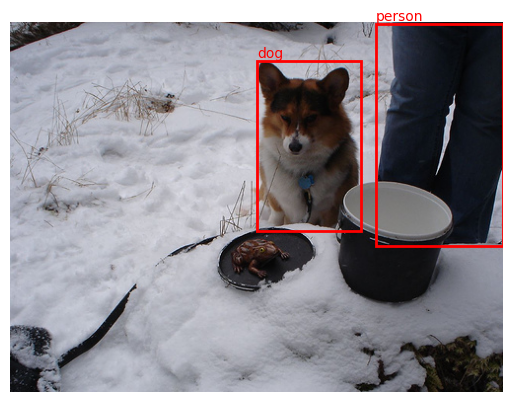

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.imshow(img1.permute(1,2,0))
ax = plt.gca()
for obj in target1['annotation']['object']:
    xmin = int(obj['bndbox']['xmin'])
    ymin = int(obj['bndbox']['ymin'])
    xmax = int(obj['bndbox']['xmax'])
    ymax = int(obj['bndbox']['ymax'])
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Add label text on top of the rectangle
    label = obj['name']
    ax.text(xmin, ymin, label, fontsize=10, color='r', verticalalignment='bottom')

plt.axis('off')
plt.show()

In [11]:
img1, target1 = train_dataset[0]
img2, target2 = test_dataset[0]
img3, target3 = val_dataset[0]
print(img1.shape, img2.shape, img3.shape)

torch.Size([3, 375, 500]) torch.Size([3, 375, 500]) torch.Size([3, 375, 500])


In [36]:
import torchvision.transforms.functional as F
def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        original_height, original_width = img.shape[1], img.shape[2]
        img = F.resize(img, (224, 224))
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        images.append(img)
        boxes = []
        labels = []
        for obj in target['annotation']['object']:
            bndbox = obj['bndbox']
            xmin = int(int(bndbox['xmin'])*scale_x)
            ymin = int(int(bndbox['ymin'])*scale_y)
            xmax = int(int(bndbox['xmax'])*scale_x)
            ymax = int(int(bndbox['ymax'])*scale_y)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(obj['name'])


        targets.append({'boxes': torch.tensor(boxes, dtype=torch.int64),
                        'labels': labels})
    return torch.stack(images), targets

In [37]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

images, targets = next(iter(train_loader))

In [41]:
images[0].shape, targets[0]

(torch.Size([3, 224, 224]),
 {'boxes': tensor([[145, 184, 174, 224],
          [ 77, 180,  87, 224],
          [ 62, 179,  77, 224]]),
  'labels': ['person', 'person', 'person']})

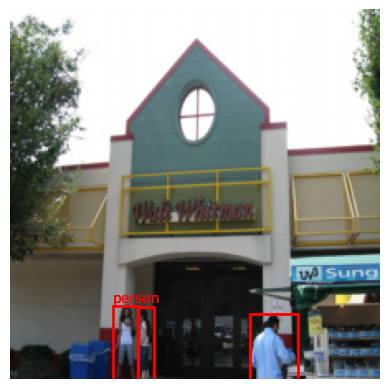

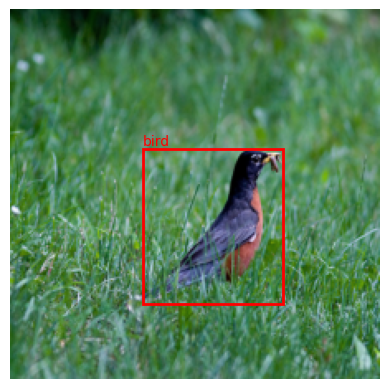

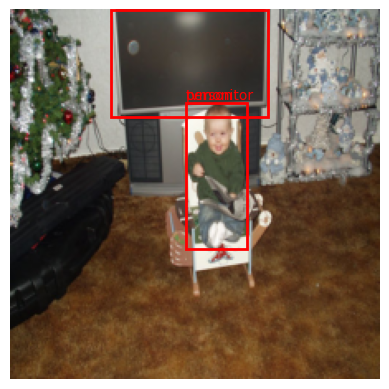

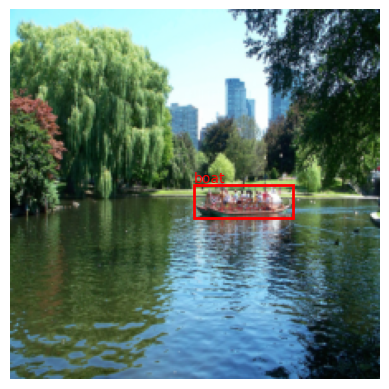

In [44]:
for img, target in zip(images, targets):
  plt.imshow(img.permute(1,2,0))
  ax = plt.gca()
  for box in target['boxes']:
    xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

  for label in target['labels']:
    ax.text(xmin, ymin, label, fontsize=10, color='r', verticalalignment='bottom')

  plt.axis('off')
  plt.show()

In [48]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [49]:
len(train_loader), len(val_loader), len(test_loader)

(1144, 1456, 286)

In [50]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 107MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(